<a href="https://colab.research.google.com/github/avyaktawrat/Evaluat-inator/blob/master/Embeddings_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [0]:
movies = pd.read_csv('https://raw.githubusercontent.com/srp98/Movie-Recommender-using-RBM/master/ml-1m/movies.dat',sep='::',header=None,engine='python',encoding='latin-1')
users = pd.read_csv('https://raw.githubusercontent.com/srp98/Movie-Recommender-using-RBM/master/ml-1m/users.dat',sep='::',header=None,engine='python',encoding='latin-1')
ratings = pd.read_csv('https://raw.githubusercontent.com/srp98/Movie-Recommender-using-RBM/master/ml-1m/ratings.dat',sep='::',header=None,engine='python',encoding='latin-1')

In [0]:
movies.columns = ['movieID', 'title', 'genres']
users.columns = ['userId', 'gender', 'zipcode', 'age_desc', 'occ_desc']
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [0]:
# training_set = pd.read_csv('https://raw.githubusercontent.com/avyaktawrat/Evaluat-inator/master/data/u1.base', delimiter='\t',header=None)
# test_set = pd.read_csv('https://raw.githubusercontent.com/avyaktawrat/Evaluat-inator/master/data/u1.test', delimiter='\t',header=None)

In [0]:
movies.head()

,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# np.unique(movies['genres'].values)

In [0]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieID  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [0]:
users.head()

,userId,gender,zipcode,age_desc,occ_desc
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [0]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userId    6040 non-null   int64 
 1   gender    6040 non-null   object
 2   zipcode   6040 non-null   int64 
 3   age_desc  6040 non-null   int64 
 4   occ_desc  6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [0]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [0]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [0]:
nb_users = int(max(max(ratings.iloc[:,0]), max(ratings.iloc[:,0])))
nb_movies = int(max(max(ratings.iloc[:,1]), max(ratings.iloc[:,1])))

In [0]:
print(nb_users)
print(nb_movies)

6040
3952


In [0]:
#removing movies which have number of ratings less than 50
#and creating list of popular movies and subsequently creating dataframe
#with ratings of movies which are in popular movies list
popularity_thres = 50
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (1000209, 4)
shape of ratings data after dropping unpopular movies:  (977839, 4)


In [0]:
# filter data
#drop ratings given by non-active users i.e. those who have given less than 50 ratings
#further creating data-frame with the users that are active and have given ratings to popular movies
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (1000209, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (920334, 4)


## Trying for a single user

In [0]:
user_id = ratings['userId'].values[0]
movies_rated_by_user = ratings['movieId'][ratings['userId'] == user_id]
ratings_given_by_user = ratings['rating'][ratings['userId'] == user_id]
print(len(movies_rated_by_user))
print(len(ratings_given_by_user))

53
53


In [0]:
print(movies_rated_by_user[:15])
print(ratings_given_by_user[:15])

0     1193
1      661
2      914
3     3408
4     2355
5     1197
6     1287
7     2804
8      594
9      919
10     595
11     938
12    2398
13    2918
14    1035
Name: movieId, dtype: int64
0     5
1     3
2     3
3     4
4     5
5     3
6     5
7     5
8     4
9     4
10    5
11    4
12    4
13    4
14    5
Name: rating, dtype: int64


In [0]:
movies_rated_by_user

0     1193
1      661
2      914
3     3408
4     2355
5     1197
6     1287
7     2804
8      594
9      919
10     595
11     938
12    2398
13    2918
14    1035
15    2791
16    2687
17    2018
18    3105
19    2797
20    2321
21     720
22    1270
23     527
24    2340
25      48
26    1097
27    1721
28    1545
29     745
30    2294
31    3186
32    1566
33     588
34    1907
35     783
36    1836
37    1022
38    2762
39     150
40       1
41    1961
42    1962
43    2692
44     260
45    1028
46    1029
47    1207
48    2028
49     531
50    3114
51     608
52    1246
Name: movieId, dtype: int64

In [0]:
class Net(nn.Module):
    def __init__(self, embedding_dim=300):
        super(Net, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(nb_movies, embedding_dim)
        self.linear = nn.Sequential(nn.ReLU(),
            nn.Linear(embedding_dim, 100),
                                    nn.ReLU(),
                                    # nn.Dropout(0.5),
                                    # nn.Linear(200,100),
                                    # nn.Tanh(),
                                    # nn.Dropout(0.5),
                                    nn.Linear(100,50),
                                    nn.ReLU(),
                                    # nn.Dropout(0.5),
                                    nn.Linear(50,25),
                                    nn.ReLU(),
                                    # nn.Dropout(0.5),
                                    # nn.Linear(25,12),
                                    # nn.Tanh(),
                                    # nn.Dropout(0.5),
                                    nn.Linear(25,10),
                                    nn.ReLU(),
                                    # nn.Dropout(0.5),
                                    # nn.Linear(6,3),
                                    # nn.Tanh(),
                                    # nn.Dropout(0.2),
                                    nn.Linear(10,5),
                                    nn.ReLU(),
        )
        self.softmax = nn.Softmax(dim=0)
    def forward(self, x):
        # x = torch.eye(nb_movies,dtype=torch.long)[x.item()]
        x = self.embedding(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [0]:
# Sanity Check
net = Net()
inp = torch.tensor(movies_rated_by_user.values[1], dtype=torch.long)
out = net(inp)
print(out.shape)

torch.Size([5])


In [0]:
net = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-6)

In [0]:
from tqdm import tqdm
train_losses = []
for epoch in range(200):
    train_loss = 0.0
    for i in tqdm(range(len(movies_rated_by_user))):
        X = torch.tensor(movies_rated_by_user.values[i], dtype=torch.long).cuda()
        Y = torch.tensor(ratings_given_by_user.values[i]-1,dtype=torch.long).cuda()
        net.zero_grad()
        output = net(X)
        loss = criterion(output.unsqueeze(0), Y.unsqueeze(0))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(movies_rated_by_user))
    print(" Epoch: {}, Loss: {}".format(epoch, train_losses[-1]))

 36%|███▌      | 19/53 [00:00<00:00, 184.46it/s]

 Epoch: 0, Loss: 1.6097425357350763


 40%|███▉      | 21/53 [00:00<00:00, 202.29it/s]

 Epoch: 1, Loss: 1.6022440644929994


 42%|████▏     | 22/53 [00:00<00:00, 211.59it/s]

 Epoch: 2, Loss: 1.5890620609499373


 42%|████▏     | 22/53 [00:00<00:00, 212.98it/s]

 Epoch: 3, Loss: 1.5705262804931064


 36%|███▌      | 19/53 [00:00<00:00, 186.64it/s]

 Epoch: 4, Loss: 1.5355273417706758


 42%|████▏     | 22/53 [00:00<00:00, 212.59it/s]

 Epoch: 5, Loss: 1.4757526753083714


 43%|████▎     | 23/53 [00:00<00:00, 221.93it/s]

 Epoch: 6, Loss: 1.4251454033941593


 42%|████▏     | 22/53 [00:00<00:00, 216.34it/s]

 Epoch: 7, Loss: 1.4045789365498524


 36%|███▌      | 19/53 [00:00<00:00, 188.17it/s]

 Epoch: 8, Loss: 1.3971680447740376


 42%|████▏     | 22/53 [00:00<00:00, 218.06it/s]

 Epoch: 9, Loss: 1.3934595719823297


 42%|████▏     | 22/53 [00:00<00:00, 217.73it/s]

 Epoch: 10, Loss: 1.39082510966175


 40%|███▉      | 21/53 [00:00<00:00, 208.24it/s]

 Epoch: 11, Loss: 1.3883375570459187


 36%|███▌      | 19/53 [00:00<00:00, 188.03it/s]

 Epoch: 12, Loss: 1.3854503339191653


 43%|████▎     | 23/53 [00:00<00:00, 221.32it/s]

 Epoch: 13, Loss: 1.3816889018382665


 36%|███▌      | 19/53 [00:00<00:00, 181.19it/s]

 Epoch: 14, Loss: 1.376309554531889


 43%|████▎     | 23/53 [00:00<00:00, 221.97it/s]

 Epoch: 15, Loss: 1.3684121145392365


 32%|███▏      | 17/53 [00:00<00:00, 168.36it/s]

 Epoch: 16, Loss: 1.357058511590058


 40%|███▉      | 21/53 [00:00<00:00, 205.37it/s]

 Epoch: 17, Loss: 1.3418205672839902


 36%|███▌      | 19/53 [00:00<00:00, 185.16it/s]

 Epoch: 18, Loss: 1.3232439205331623


 42%|████▏     | 22/53 [00:00<00:00, 216.37it/s]

 Epoch: 19, Loss: 1.3019492828621055


 40%|███▉      | 21/53 [00:00<00:00, 208.98it/s]

 Epoch: 20, Loss: 1.2858204504228987


 42%|████▏     | 22/53 [00:00<00:00, 213.94it/s]

 Epoch: 21, Loss: 1.2730132723754306


 40%|███▉      | 21/53 [00:00<00:00, 209.85it/s]

 Epoch: 22, Loss: 1.2631680358130977


 34%|███▍      | 18/53 [00:00<00:00, 176.12it/s]

 Epoch: 23, Loss: 1.2557326409052003


 40%|███▉      | 21/53 [00:00<00:00, 207.44it/s]

 Epoch: 24, Loss: 1.2481413955958385


 42%|████▏     | 22/53 [00:00<00:00, 217.55it/s]

 Epoch: 25, Loss: 1.2414855282261688


 40%|███▉      | 21/53 [00:00<00:00, 209.70it/s]

 Epoch: 26, Loss: 1.2337841965117544


 40%|███▉      | 21/53 [00:00<00:00, 208.57it/s]

 Epoch: 27, Loss: 1.226855605278375


 40%|███▉      | 21/53 [00:00<00:00, 206.42it/s]

 Epoch: 28, Loss: 1.2147901980382092


 38%|███▊      | 20/53 [00:00<00:00, 196.83it/s]

 Epoch: 29, Loss: 1.1998157073866647


 42%|████▏     | 22/53 [00:00<00:00, 212.75it/s]

 Epoch: 30, Loss: 1.1741654040678493


 34%|███▍      | 18/53 [00:00<00:00, 176.03it/s]

 Epoch: 31, Loss: 1.135606401371506


 36%|███▌      | 19/53 [00:00<00:00, 184.79it/s]

 Epoch: 32, Loss: 1.0864151682493821


 36%|███▌      | 19/53 [00:00<00:00, 189.28it/s]

 Epoch: 33, Loss: 1.0509063545263038


 38%|███▊      | 20/53 [00:00<00:00, 197.35it/s]

 Epoch: 34, Loss: 1.0221446741302058


 40%|███▉      | 21/53 [00:00<00:00, 202.91it/s]

 Epoch: 35, Loss: 0.9911711980711739


 42%|████▏     | 22/53 [00:00<00:00, 218.43it/s]

 Epoch: 36, Loss: 0.9614013231025552


 42%|████▏     | 22/53 [00:00<00:00, 213.55it/s]

 Epoch: 37, Loss: 0.9434146656180328


 43%|████▎     | 23/53 [00:00<00:00, 223.46it/s]

 Epoch: 38, Loss: 0.9316482667653065


 42%|████▏     | 22/53 [00:00<00:00, 215.37it/s]

 Epoch: 39, Loss: 0.924742119492225


 43%|████▎     | 23/53 [00:00<00:00, 225.28it/s]

 Epoch: 40, Loss: 0.919838861474451


 43%|████▎     | 23/53 [00:00<00:00, 224.49it/s]

 Epoch: 41, Loss: 0.9164324593993852


 40%|███▉      | 21/53 [00:00<00:00, 202.06it/s]

 Epoch: 42, Loss: 0.9141330145440012


 40%|███▉      | 21/53 [00:00<00:00, 206.84it/s]

 Epoch: 43, Loss: 0.912480633213835


 40%|███▉      | 21/53 [00:00<00:00, 208.54it/s]

 Epoch: 44, Loss: 0.9112597152871905


 36%|███▌      | 19/53 [00:00<00:00, 189.79it/s]

 Epoch: 45, Loss: 0.9103539619805678


 40%|███▉      | 21/53 [00:00<00:00, 207.09it/s]

 Epoch: 46, Loss: 0.9096115040329268


 40%|███▉      | 21/53 [00:00<00:00, 209.96it/s]

 Epoch: 47, Loss: 0.9090271614632517


 42%|████▏     | 22/53 [00:00<00:00, 217.40it/s]

 Epoch: 48, Loss: 0.908560926059507


 38%|███▊      | 20/53 [00:00<00:00, 199.59it/s]

 Epoch: 49, Loss: 0.9081399946842553


 36%|███▌      | 19/53 [00:00<00:00, 189.24it/s]

 Epoch: 50, Loss: 0.9078041168878663


 42%|████▏     | 22/53 [00:00<00:00, 214.46it/s]

 Epoch: 51, Loss: 0.9075227267337296


 43%|████▎     | 23/53 [00:00<00:00, 220.95it/s]

 Epoch: 52, Loss: 0.9072670036891721


 38%|███▊      | 20/53 [00:00<00:00, 195.85it/s]

 Epoch: 53, Loss: 0.9070533817669131


 38%|███▊      | 20/53 [00:00<00:00, 192.05it/s]

 Epoch: 54, Loss: 0.9068622173003431


 40%|███▉      | 21/53 [00:00<00:00, 208.91it/s]

 Epoch: 55, Loss: 0.9066931819016079


 42%|████▏     | 22/53 [00:00<00:00, 214.40it/s]

 Epoch: 56, Loss: 0.906543234609208


 40%|███▉      | 21/53 [00:00<00:00, 201.76it/s]

 Epoch: 57, Loss: 0.9064111034825163


 40%|███▉      | 21/53 [00:00<00:00, 208.50it/s]

 Epoch: 58, Loss: 0.906293344947527


 36%|███▌      | 19/53 [00:00<00:00, 182.57it/s]

 Epoch: 59, Loss: 0.9061831359593373


 40%|███▉      | 21/53 [00:00<00:00, 209.38it/s]

 Epoch: 60, Loss: 0.9060541560065072


 42%|████▏     | 22/53 [00:00<00:00, 210.55it/s]

 Epoch: 61, Loss: 0.9059387096818888


 40%|███▉      | 21/53 [00:00<00:00, 200.44it/s]

 Epoch: 62, Loss: 0.9058447558924837


 43%|████▎     | 23/53 [00:00<00:00, 223.12it/s]

 Epoch: 63, Loss: 0.9057637779217846


 40%|███▉      | 21/53 [00:00<00:00, 196.05it/s]

 Epoch: 64, Loss: 0.9056895611421117


 34%|███▍      | 18/53 [00:00<00:00, 175.73it/s]

 Epoch: 65, Loss: 0.905625786421434


 42%|████▏     | 22/53 [00:00<00:00, 211.51it/s]

 Epoch: 66, Loss: 0.9055666608630486


 42%|████▏     | 22/53 [00:00<00:00, 218.35it/s]

 Epoch: 67, Loss: 0.9055151264622526


 36%|███▌      | 19/53 [00:00<00:00, 189.28it/s]

 Epoch: 68, Loss: 0.905469518787456


 38%|███▊      | 20/53 [00:00<00:00, 197.62it/s]

 Epoch: 69, Loss: 0.9054266518017031


 42%|████▏     | 22/53 [00:00<00:00, 214.69it/s]

 Epoch: 70, Loss: 0.9053901816314122


 40%|███▉      | 21/53 [00:00<00:00, 204.68it/s]

 Epoch: 71, Loss: 0.9053540499705188


 38%|███▊      | 20/53 [00:00<00:00, 196.56it/s]

 Epoch: 72, Loss: 0.9053207073571548


 42%|████▏     | 22/53 [00:00<00:00, 214.74it/s]

 Epoch: 73, Loss: 0.9052917529951852


 40%|███▉      | 21/53 [00:00<00:00, 209.04it/s]

 Epoch: 74, Loss: 0.9052641819108207


 38%|███▊      | 20/53 [00:00<00:00, 190.59it/s]

 Epoch: 75, Loss: 0.9052385406674079


 42%|████▏     | 22/53 [00:00<00:00, 215.16it/s]

 Epoch: 76, Loss: 0.9052154984114305


 42%|████▏     | 22/53 [00:00<00:00, 215.00it/s]

 Epoch: 77, Loss: 0.9051941869393835


 40%|███▉      | 21/53 [00:00<00:00, 208.60it/s]

 Epoch: 78, Loss: 0.9051745995035712


 38%|███▊      | 20/53 [00:00<00:00, 196.17it/s]

 Epoch: 79, Loss: 0.9051555946188153


 42%|████▏     | 22/53 [00:00<00:00, 217.05it/s]

 Epoch: 80, Loss: 0.9051385072042357


 40%|███▉      | 21/53 [00:00<00:00, 207.96it/s]

 Epoch: 81, Loss: 0.9051224386916971


 40%|███▉      | 21/53 [00:00<00:00, 209.91it/s]

 Epoch: 82, Loss: 0.9051074790504744


 36%|███▌      | 19/53 [00:00<00:00, 183.61it/s]

 Epoch: 83, Loss: 0.9050936980067559


 40%|███▉      | 21/53 [00:00<00:00, 198.78it/s]

 Epoch: 84, Loss: 0.9050802880862974


 42%|████▏     | 22/53 [00:00<00:00, 217.67it/s]

 Epoch: 85, Loss: 0.9050678622047856


 38%|███▊      | 20/53 [00:00<00:00, 195.50it/s]

 Epoch: 86, Loss: 0.9050564765930176


 42%|████▏     | 22/53 [00:00<00:00, 216.75it/s]

 Epoch: 87, Loss: 0.9050458073616028


 38%|███▊      | 20/53 [00:00<00:00, 193.53it/s]

 Epoch: 88, Loss: 0.9050353000748832


 40%|███▉      | 21/53 [00:00<00:00, 208.98it/s]

 Epoch: 89, Loss: 0.9050256283778064


 42%|████▏     | 22/53 [00:00<00:00, 219.09it/s]

 Epoch: 90, Loss: 0.9050167742765175


 42%|████▏     | 22/53 [00:00<00:00, 217.57it/s]

 Epoch: 91, Loss: 0.9050084498693358


 36%|███▌      | 19/53 [00:00<00:00, 187.56it/s]

 Epoch: 92, Loss: 0.9050001783191033


 42%|████▏     | 22/53 [00:00<00:00, 217.32it/s]

 Epoch: 93, Loss: 0.9049928064616222


 40%|███▉      | 21/53 [00:00<00:00, 196.42it/s]

 Epoch: 94, Loss: 0.9049853311394745


 38%|███▊      | 20/53 [00:00<00:00, 196.01it/s]

 Epoch: 95, Loss: 0.9049788443547375


 40%|███▉      | 21/53 [00:00<00:00, 204.24it/s]

 Epoch: 96, Loss: 0.9049722496068703


 40%|███▉      | 21/53 [00:00<00:00, 207.22it/s]

 Epoch: 97, Loss: 0.9049661991731176


 32%|███▏      | 17/53 [00:00<00:00, 166.68it/s]

 Epoch: 98, Loss: 0.9049603939056396


 40%|███▉      | 21/53 [00:00<00:00, 203.96it/s]

 Epoch: 99, Loss: 0.9049551273291966


 42%|████▏     | 22/53 [00:00<00:00, 214.47it/s]

 Epoch: 100, Loss: 0.90495000020513


 38%|███▊      | 20/53 [00:00<00:00, 192.10it/s]

 Epoch: 101, Loss: 0.904945008034976


 40%|███▉      | 21/53 [00:00<00:00, 208.30it/s]

 Epoch: 102, Loss: 0.9049402261680027


 36%|███▌      | 19/53 [00:00<00:00, 189.17it/s]

 Epoch: 103, Loss: 0.9049358817766298


 38%|███▊      | 20/53 [00:00<00:00, 196.80it/s]

 Epoch: 104, Loss: 0.9049315744975828


 42%|████▏     | 22/53 [00:00<00:00, 214.46it/s]

 Epoch: 105, Loss: 0.9049275303786656


 42%|████▏     | 22/53 [00:00<00:00, 211.32it/s]

 Epoch: 106, Loss: 0.9049235919736466


 36%|███▌      | 19/53 [00:00<00:00, 182.92it/s]

 Epoch: 107, Loss: 0.9049200842965324


 42%|████▏     | 22/53 [00:00<00:00, 217.89it/s]

 Epoch: 108, Loss: 0.9049165125163097


 36%|███▌      | 19/53 [00:00<00:00, 189.63it/s]

 Epoch: 109, Loss: 0.9049132218900716


 40%|███▉      | 21/53 [00:00<00:00, 209.88it/s]

 Epoch: 110, Loss: 0.9049099458838409


 42%|████▏     | 22/53 [00:00<00:00, 217.75it/s]

 Epoch: 111, Loss: 0.904907060119341


 34%|███▍      | 18/53 [00:00<00:00, 175.96it/s]

 Epoch: 112, Loss: 0.9049041001301892


 38%|███▊      | 20/53 [00:00<00:00, 192.60it/s]

 Epoch: 113, Loss: 0.9049013234534353


 40%|███▉      | 21/53 [00:00<00:00, 208.49it/s]

 Epoch: 114, Loss: 0.9048987357121594


 40%|███▉      | 21/53 [00:00<00:00, 207.19it/s]

 Epoch: 115, Loss: 0.904896190706289


 42%|████▏     | 22/53 [00:00<00:00, 215.74it/s]

 Epoch: 116, Loss: 0.9048937469158532


 40%|███▉      | 21/53 [00:00<00:00, 209.38it/s]

 Epoch: 117, Loss: 0.9048914526993374


 42%|████▏     | 22/53 [00:00<00:00, 212.59it/s]

 Epoch: 118, Loss: 0.9048892203366982


 43%|████▎     | 23/53 [00:00<00:00, 226.27it/s]

 Epoch: 119, Loss: 0.9048871982772395


 42%|████▏     | 22/53 [00:00<00:00, 217.62it/s]

 Epoch: 120, Loss: 0.9048851705947012


 40%|███▉      | 21/53 [00:00<00:00, 205.59it/s]

 Epoch: 121, Loss: 0.9048832609968366


 36%|███▌      | 19/53 [00:00<00:00, 182.24it/s]

 Epoch: 122, Loss: 0.9048813289066531


 43%|████▎     | 23/53 [00:00<00:00, 221.53it/s]

 Epoch: 123, Loss: 0.9048795452657735


 40%|███▉      | 21/53 [00:00<00:00, 206.14it/s]

 Epoch: 124, Loss: 0.9048778212295389


 42%|████▏     | 22/53 [00:00<00:00, 208.01it/s]

 Epoch: 125, Loss: 0.9048762602626153


 36%|███▌      | 19/53 [00:00<00:00, 188.60it/s]

 Epoch: 126, Loss: 0.904874676803373


 36%|███▌      | 19/53 [00:00<00:00, 185.75it/s]

 Epoch: 127, Loss: 0.9048731113379856


 38%|███▊      | 20/53 [00:00<00:00, 192.71it/s]

 Epoch: 128, Loss: 0.9048717258111486


 40%|███▉      | 21/53 [00:00<00:00, 204.23it/s]

 Epoch: 129, Loss: 0.9048703009227537


 43%|████▎     | 23/53 [00:00<00:00, 222.05it/s]

 Epoch: 130, Loss: 0.9048689794990251


 42%|████▏     | 22/53 [00:00<00:00, 215.96it/s]

 Epoch: 131, Loss: 0.9048676816922314


 43%|████▎     | 23/53 [00:00<00:00, 221.36it/s]

 Epoch: 132, Loss: 0.9048664446146983


 42%|████▏     | 22/53 [00:00<00:00, 218.20it/s]

 Epoch: 133, Loss: 0.9048653132510636


 40%|███▉      | 21/53 [00:00<00:00, 207.12it/s]

 Epoch: 134, Loss: 0.9048641447751027


 40%|███▉      | 21/53 [00:00<00:00, 209.19it/s]

 Epoch: 135, Loss: 0.9048630876361199


 40%|███▉      | 21/53 [00:00<00:00, 206.80it/s]

 Epoch: 136, Loss: 0.9048620057555864


 38%|███▊      | 20/53 [00:00<00:00, 198.26it/s]

 Epoch: 137, Loss: 0.9048609891027775


 42%|████▏     | 22/53 [00:00<00:00, 214.79it/s]

 Epoch: 138, Loss: 0.9048600129361423


 40%|███▉      | 21/53 [00:00<00:00, 208.61it/s]

 Epoch: 139, Loss: 0.9048590615110578


 38%|███▊      | 20/53 [00:00<00:00, 199.77it/s]

 Epoch: 140, Loss: 0.904858188809089


 38%|███▊      | 20/53 [00:00<00:00, 193.10it/s]

 Epoch: 141, Loss: 0.9048573341009751


 36%|███▌      | 19/53 [00:00<00:00, 187.40it/s]

 Epoch: 142, Loss: 0.9048564591497745


 38%|███▊      | 20/53 [00:00<00:00, 193.64it/s]

 Epoch: 143, Loss: 0.9048556786663128


 42%|████▏     | 22/53 [00:00<00:00, 216.38it/s]

 Epoch: 144, Loss: 0.9048548711920684


 40%|███▉      | 21/53 [00:00<00:00, 208.17it/s]

 Epoch: 145, Loss: 0.9048541806778818


 40%|███▉      | 21/53 [00:00<00:00, 206.07it/s]

 Epoch: 146, Loss: 0.9048534271852026


 38%|███▊      | 20/53 [00:00<00:00, 196.50it/s]

 Epoch: 147, Loss: 0.9048527636617985


 42%|████▏     | 22/53 [00:00<00:00, 215.94it/s]

 Epoch: 148, Loss: 0.904852068649148


 34%|███▍      | 18/53 [00:00<00:00, 175.41it/s]

 Epoch: 149, Loss: 0.904851423119599


 43%|████▎     | 23/53 [00:00<00:00, 223.65it/s]

 Epoch: 150, Loss: 0.9048508158269918


 42%|████▏     | 22/53 [00:00<00:00, 214.02it/s]

 Epoch: 151, Loss: 0.904850165798979


 40%|███▉      | 21/53 [00:00<00:00, 205.47it/s]

 Epoch: 152, Loss: 0.9048496259833282


 40%|███▉      | 21/53 [00:00<00:00, 203.75it/s]

 Epoch: 153, Loss: 0.9048490681738224


 40%|███▉      | 21/53 [00:00<00:00, 203.73it/s]

 Epoch: 154, Loss: 0.9048485058658527


 38%|███▊      | 20/53 [00:00<00:00, 196.50it/s]

 Epoch: 155, Loss: 0.9048480267794627


 40%|███▉      | 21/53 [00:00<00:00, 200.31it/s]

 Epoch: 156, Loss: 0.9048475139545944


 42%|████▏     | 22/53 [00:00<00:00, 216.27it/s]

 Epoch: 157, Loss: 0.9048470326189725


 36%|███▌      | 19/53 [00:00<00:00, 189.93it/s]

 Epoch: 158, Loss: 0.9048465715264374


 40%|███▉      | 21/53 [00:00<00:00, 209.65it/s]

 Epoch: 159, Loss: 0.9048461239292936


 32%|███▏      | 17/53 [00:00<00:00, 164.29it/s]

 Epoch: 160, Loss: 0.9048456853290774


 43%|████▎     | 23/53 [00:00<00:00, 222.88it/s]

 Epoch: 161, Loss: 0.9048452737196436


 43%|████▎     | 23/53 [00:00<00:00, 223.82it/s]

 Epoch: 162, Loss: 0.9048448576117462


 42%|████▏     | 22/53 [00:00<00:00, 214.79it/s]

 Epoch: 163, Loss: 0.9048444774915587


 42%|████▏     | 22/53 [00:00<00:00, 210.81it/s]

 Epoch: 164, Loss: 0.9048440883744437


 42%|████▏     | 22/53 [00:00<00:00, 214.22it/s]

 Epoch: 165, Loss: 0.9048437195004158


 42%|████▏     | 22/53 [00:00<00:00, 214.35it/s]

 Epoch: 166, Loss: 0.9048433866140977


 42%|████▏     | 22/53 [00:00<00:00, 213.65it/s]

 Epoch: 167, Loss: 0.9048430379831566


 42%|████▏     | 22/53 [00:00<00:00, 215.33it/s]

 Epoch: 168, Loss: 0.904842716342998


 42%|████▏     | 22/53 [00:00<00:00, 213.67it/s]

 Epoch: 169, Loss: 0.9048424014505351


 42%|████▏     | 22/53 [00:00<00:00, 212.19it/s]

 Epoch: 170, Loss: 0.9048420955549996


 42%|████▏     | 22/53 [00:00<00:00, 214.09it/s]

 Epoch: 171, Loss: 0.9048418166502467


 43%|████▎     | 23/53 [00:00<00:00, 223.68it/s]

 Epoch: 172, Loss: 0.9048415107547112


 38%|███▊      | 20/53 [00:00<00:00, 188.14it/s]

 Epoch: 173, Loss: 0.9048412475945815


 42%|████▏     | 22/53 [00:00<00:00, 212.16it/s]

 Epoch: 174, Loss: 0.904840959692901


 42%|████▏     | 22/53 [00:00<00:00, 216.99it/s]

 Epoch: 175, Loss: 0.9048407122773944


 43%|████▎     | 23/53 [00:00<00:00, 221.60it/s]

 Epoch: 176, Loss: 0.9048404761080472


 40%|███▉      | 21/53 [00:00<00:00, 207.16it/s]

 Epoch: 177, Loss: 0.9048402196956131


 34%|███▍      | 18/53 [00:00<00:00, 175.35it/s]

 Epoch: 178, Loss: 0.9048399925231934


 38%|███▊      | 20/53 [00:00<00:00, 195.85it/s]

 Epoch: 179, Loss: 0.9048397855938606


 32%|███▏      | 17/53 [00:00<00:00, 164.89it/s]

 Epoch: 180, Loss: 0.9048395539229771


 42%|████▏     | 22/53 [00:00<00:00, 216.47it/s]

 Epoch: 181, Loss: 0.9048393447444124


 42%|████▏     | 22/53 [00:00<00:00, 215.58it/s]

 Epoch: 182, Loss: 0.904839167055094


 36%|███▌      | 19/53 [00:00<00:00, 182.95it/s]

 Epoch: 183, Loss: 0.9048389488796018


 43%|████▎     | 23/53 [00:00<00:00, 226.15it/s]

 Epoch: 184, Loss: 0.9048387689410515


 43%|████▎     | 23/53 [00:00<00:00, 220.45it/s]

 Epoch: 185, Loss: 0.9048385935009651


 40%|███▉      | 21/53 [00:00<00:00, 203.36it/s]

 Epoch: 186, Loss: 0.9048384158116467


 43%|████▎     | 23/53 [00:00<00:00, 221.66it/s]

 Epoch: 187, Loss: 0.9048382471192558


 42%|████▏     | 22/53 [00:00<00:00, 218.94it/s]

 Epoch: 188, Loss: 0.904838058183778


 40%|███▉      | 21/53 [00:00<00:00, 207.25it/s]

 Epoch: 189, Loss: 0.9048379232298653


 38%|███▊      | 20/53 [00:00<00:00, 195.58it/s]

 Epoch: 190, Loss: 0.9048377567867063


 43%|████▎     | 23/53 [00:00<00:00, 228.01it/s]

 Epoch: 191, Loss: 0.9048376240820255


 38%|███▊      | 20/53 [00:00<00:00, 191.67it/s]

 Epoch: 192, Loss: 0.9048374778819535


 43%|████▎     | 23/53 [00:00<00:00, 223.03it/s]

 Epoch: 193, Loss: 0.9048373294326494


 43%|████▎     | 23/53 [00:00<00:00, 223.25it/s]

 Epoch: 194, Loss: 0.9048371764848817


 42%|████▏     | 22/53 [00:00<00:00, 213.89it/s]

 Epoch: 195, Loss: 0.904837041530969


 43%|████▎     | 23/53 [00:00<00:00, 226.29it/s]

 Epoch: 196, Loss: 0.9048369178232157


 43%|████▎     | 23/53 [00:00<00:00, 225.10it/s]

 Epoch: 197, Loss: 0.9048367851185348


 38%|███▊      | 20/53 [00:00<00:00, 197.32it/s]

 Epoch: 198, Loss: 0.9048366546630859


100%|██████████| 53/53 [00:00<00:00, 203.92it/s]

 Epoch: 199, Loss: 0.9048365332045645


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


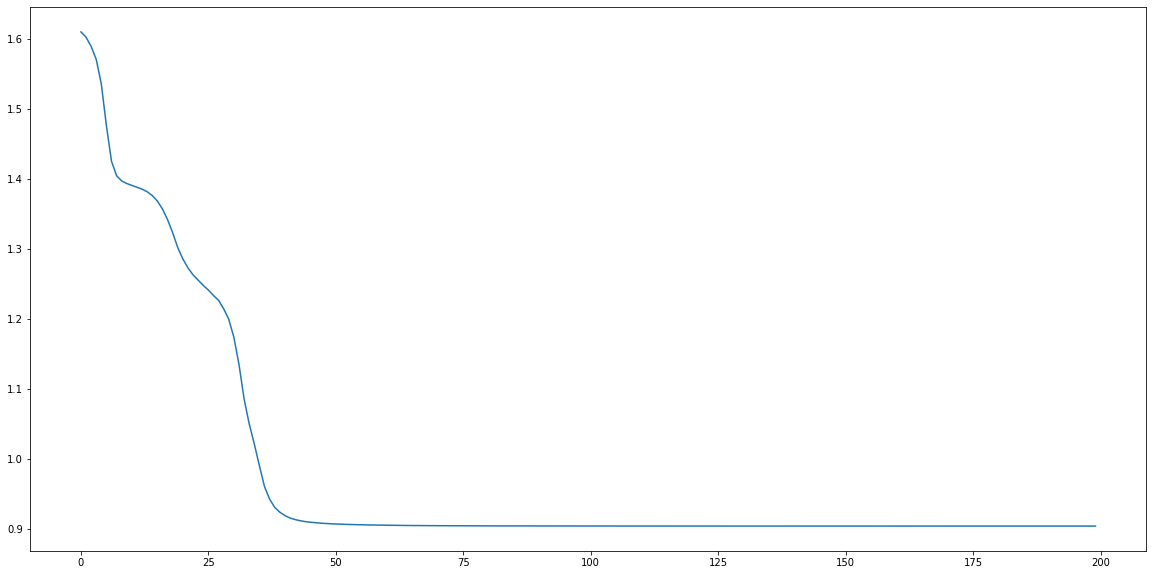

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(train_losses)
# fig.savefig('/content/drive/My Drive/losscurve.png')
plt.show()

In [0]:
test_inp = ratings['movieId'][ratings['userId'] != user_id]
test_inp = torch.tensor(test_inp.values, dtype=torch.long).cuda()
out = net(test_inp)
# print(out.shape)

idxs = []
for i in range(out.shape[0]):
    if torch.argmax(out[i]) >= 4:
        idxs.append(i)

# print(len(idxs))
movie_dict = {idx:title for idx, title in zip(movies['movieID'],movies['title'])}
# print(len(movie_dict))
recommended = []
for idx in idxs:
    try:
        recommended.append(movie_dict[idx])
    except:
        pass
from pprint import pprint
pprint(recommended[:10])

['Ace Ventura: When Nature Calls (1995)',
 'Big Green, The (1995)',
 'Two Bits (1995)',
 'Congo (1995)',
 'First Knight (1995)',
 'Johnny Mnemonic (1995)',
 'Nine Months (1995)',
 'Hideaway (1995)',
 'Ladybird Ladybird (1994)',
 'Shallow Grave (1994)']
